In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
# Experiment setup
experiment_name = '1801'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

In [24]:
# Classification parameters and setup
time_window = 50
time_step = 25
trial_average = 20
n_splits = 5
group_dict = {0:[2],1:[3]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub,num_labels=2)
from sklearn.metrics import confusion_matrix


In [27]:
# If you want to retrain classifiers, run this cell. Otherwise run next cell.

for isub in range(exp.nsub):
    print(isub)
    xdata,ydata = exp.load_eeg(isub)
    xdata,ydata = wrangl.setup_data(xdata,ydata)
    
    for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
        X_test_all, y_test = wrangl.balance_labels(X_test_all,y_test)
        y_test_shuffle = np.random.permutation(y_test)
        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            # clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)
            X_train, X_test = clfr.standardize(X_train, X_test)
            clfr.classifier.fit(X_train, y_train)
            clfr.conf_mat[isub,wrangl.itime,wrangl.ifold] = confusion_matrix(y_test,y_pred=clfr.classifier.predict(X_test),normalize='true')

# Set up interp object and save results
interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


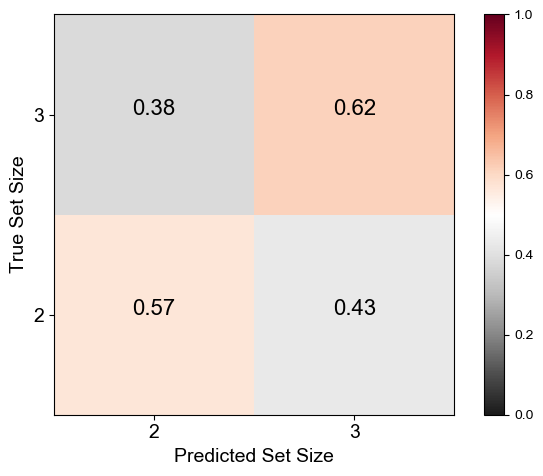

In [54]:
interp.plot_conf_mat()

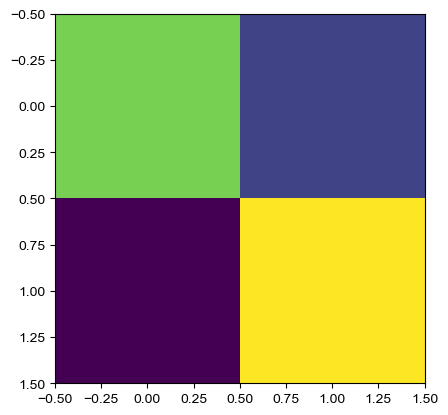

[[0.56780303 0.43219697]
 [0.38454545 0.61545455]]


0.38454545454545447

In [29]:
        
cm = np.mean(np.mean(np.mean(interp.conf_mat[:,interp.t>250],2),1),0)

#Normalize
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm)
plt.show()
print(cm)
# cm[0,1] 2 predicted as 3
# cm[1,0] 3 predicted as 2

In [47]:
import scipy.stats as sista
cm = np.mean(interp.conf_mat,2)
ss2as3 = cm[:,:,0,1]
ss3as2 = cm[:,:,1,0]
ss2as3_mean = np.mean(ss2as3,0)
ss3as2_mean = np.mean(ss3as2,0)
ss2as3_sem = sista.sem(ss2as3,0)
ss3as2_sem = sista.sem(ss3as2,0)
ss2as3_upper = ss2as3_mean + ss2as3_sem
ss2as3_lower = ss2as3_mean - ss2as3_sem
ss3as2_upper = ss3as2_mean + ss3as2_sem
ss3as2_lower = ss3as2_mean - ss3as2_sem

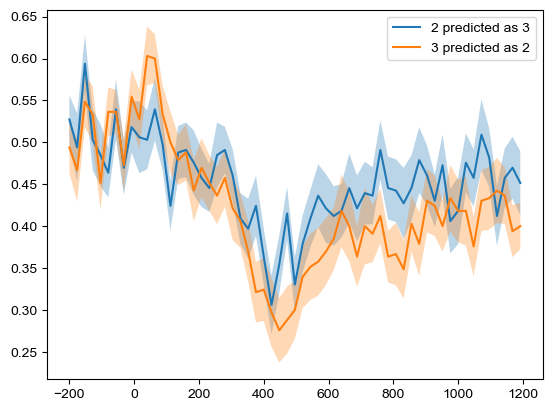

In [53]:
plt.plot(wrangl.t,ss2as3_mean,label = '2 predicted as 3')
plt.fill_between(wrangl.t,ss2as3_upper,ss2as3_lower,alpha=.3)
plt.plot(wrangl.t,ss3as2_mean,label = '3 predicted as 2')
plt.fill_between(wrangl.t,ss3as2_upper,ss3as2_lower,alpha=.3)
plt.legend()
plt.show()

In [4]:
# Set up interp object and load pre-existing results. Skip if you ran previous cell.
interp = decode_eeg.Interpreter()
interp.load_results('1801_trialbin20.pickle')

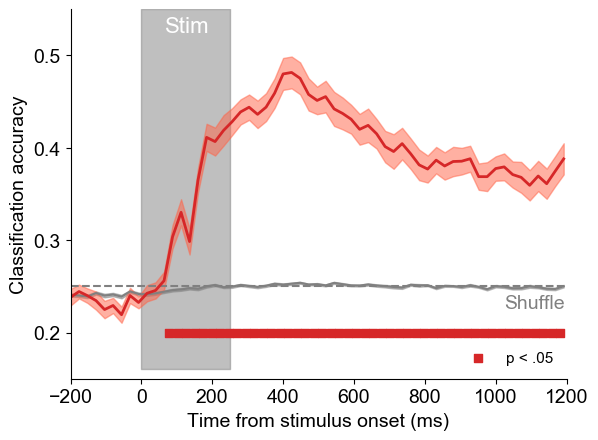

Significant timepoints: [  88  112  136  160  184  208  232  256  280  304  328  352  376  400
  424  448  472  496  520  544  568  592  616  640  664  688  712  736
  760  784  808  832  856  880  904  928  952  976 1000 1024 1048 1072
 1096 1120 1144 1168 1192]
Mean delay accuracy: 0.4095879310966811
Mean delay S.D.: 0.03604939706301303


In [8]:
interp.plot_acc(significance_testing=True,savefig=False,ylim=[.15,.55],chance_text_y=.23)

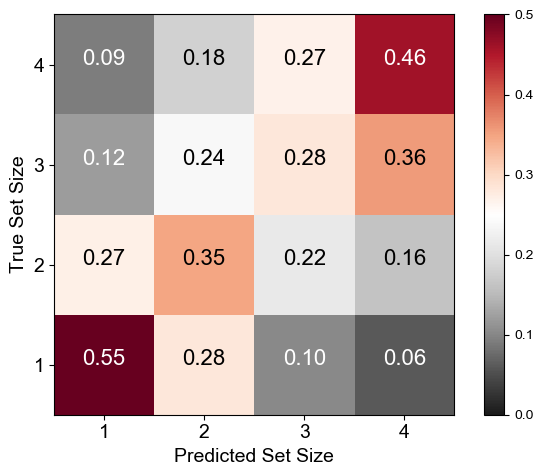

In [7]:
interp.plot_conf_mat(upper=.5,lower=0, savefig=False)